### SEGAN without the GAN

Original SEGAN paper: https://arxiv.org/pdf/1703.09452.pdf

In [52]:
import os
import torch
from torch import nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchaudio import transforms
from data import CleanSpeechDataset
import time
from model import Autoencoder
import pdb
import matplotlib.pyplot as plt
from pypesq import pesq

In [19]:
import torch
from torch import nn
from torch.autograd import Variable
from torchaudio import transforms
import torch.nn.functional as F
import torchaudio

In [20]:
num_epochs = 50
batch_size = 1024
learning_rate = 0.00003

If you'd like to run the training loop, download the OpenSLR12 dataset (http://www.openslr.org/12/) and copy all the wav files to 'data/clean/open_slr'

In [21]:
dataset = CleanSpeechDataset('data/clean/open_slr/', 8192, 50)

In [22]:
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

In [24]:
model = Autoencoder().cuda()
criterion = nn.MSELoss()
optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate, weight_decay=1e-5)

model.train()

# data = next(iter(dataloader))
for epoch in range(num_epochs):
    start = time.time()

    for i, data in enumerate(dataloader):
        sample = data
        sample = Variable(sample).cuda()
        output = model(sample)
        loss = criterion(output, sample)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    if epoch == 0:
        time_diff = time.time() - start
        print(f'Epoch took {round(time_diff, 4)}s')
        print(f'Expected hours to train: {round(time_diff * num_epochs / 3600, 2) }')
    if epoch % 5 == 0:
        print(f'epoch [{epoch}/{num_epochs}]')
        print(round(loss.item(), 5))

Epoch took 117.7682s
Expected hours to train: 3.271337628364563
epoch [0/100]
0.00306
epoch [5/100]
0.00119
epoch [10/100]
0.00094
epoch [15/100]
0.0008
epoch [20/100]
0.00073
epoch [25/100]
0.00067
epoch [30/100]
0.00064
epoch [35/100]
0.00063
epoch [40/100]
0.00062
epoch [45/100]
0.00061
epoch [50/100]
0.0006
epoch [55/100]
0.0006
epoch [60/100]
0.00059
epoch [65/100]
0.00059
epoch [70/100]
0.00058
epoch [75/100]
0.00058
epoch [80/100]
0.00057
epoch [85/100]
0.00059
epoch [90/100]
0.00056
epoch [95/100]
0.00055


In [25]:
model

Autoencoder(
  (in_dropout): Dropout(p=0.3, inplace=False)
  (conv_1): Conv1d(1, 16, kernel_size=(32,), stride=(2,), padding=(15,))
  (norm_1): PReLU(num_parameters=1)
  (conv_2): Conv1d(16, 32, kernel_size=(32,), stride=(2,), padding=(15,))
  (norm_2): PReLU(num_parameters=1)
  (conv_3): Conv1d(32, 32, kernel_size=(32,), stride=(2,), padding=(15,))
  (norm_3): PReLU(num_parameters=1)
  (conv_4): Conv1d(32, 64, kernel_size=(32,), stride=(2,), padding=(15,))
  (norm_4): PReLU(num_parameters=1)
  (conv_5): Conv1d(64, 64, kernel_size=(32,), stride=(2,), padding=(15,))
  (norm_5): PReLU(num_parameters=1)
  (conv_6): Conv1d(64, 128, kernel_size=(32,), stride=(2,), padding=(15,))
  (norm_6): PReLU(num_parameters=1)
  (conv_7): Conv1d(128, 128, kernel_size=(32,), stride=(2,), padding=(15,))
  (norm_7): PReLU(num_parameters=1)
  (conv_8): Conv1d(128, 256, kernel_size=(32,), stride=(2,), padding=(15,))
  (norm_8): PReLU(num_parameters=1)
  (conv_9): Conv1d(256, 256, kernel_size=(32,), stride=(2

3.7014033794403076


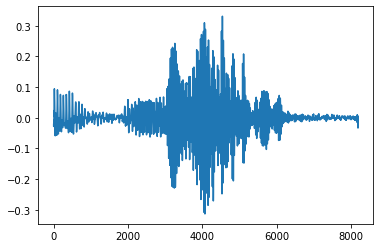

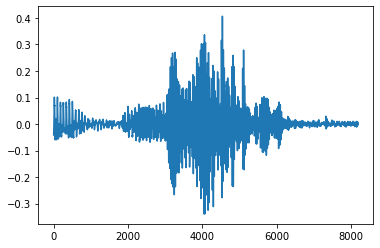

In [61]:
model.eval()
with torch.no_grad():
    sample = data.cuda()
    n = 300
    output = model(sample)
    ref = output[n, :, :].cpu().detach().numpy().T
    target = sample[n, :, :].cpu().detach().numpy().T
    plt.figure()
    plt.plot(ref)
    plt.figure()
    plt.plot(target)
    
    p_score  = pesq(ref[:, 0], target[:, 0], 16000)
    print(p_score)

In [51]:
torch.save(model.state_dict(), 'models/seae.pth')

In [ ]:
f = 'data/clean/open_slr/2902-9006-0001.wav'
wave, _ = torchaudio.load(f)
specgram = torchaudio.transforms.Spectrogram(1024, 300)(wave)

print("Shape of spectrogram: {}".format(specgram.size()))

plt.figure()
plt.imshow(specgram.log2()[0,:,:].numpy())